# Novartis Data Science Challenge

###### My approach to the given problem:

In this problem, I clearly understood that more than Accuracy we have to select a **model that provides less False Negative** (FN) because not detecting an Attack that is actually going to take place is much costlier than falsely detecting that an attack will take place where the attack is not going to take place. 

Preprocessing steps:
1. Impute the Missing Data
2. Create Day, Month and Year as individual features
3. Checking Multicollinearity and handling it
4. Removing the unwanted features
5. Standardizing the data

Post this I split the data into Train and Valid dataset(70-30 Split). I've used seven different models on the Train dataset to determine the best model to use on the Test dataset. I perform Cross-Validation on different models and calculate accuracy and standard deviation to understand how the model has performed. I even check the confusion matrix to check how good a model has performed and then check the value of False Negative. After checking I select the model that I'll be using on Test dataset to predict the MULTIPLE_OFFENSE.

For this Dataset **GradientBoostingClassifier** has performed very well with only **One False Negative** and the **recall score** is also **best** for this method.


At last, I performed preprocessing on the test dataset (as mentioned above) and used **GradientBoostingClassifier** to predict the Response(MULTIPLE_OFFENSE)

In [57]:
# calling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from joblib import Parallel, delayed
from sklearn.model_selection import KFold

from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score


import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_columns', 99999)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.act_node_interactivity = 'all'

# Train File

In [2]:
train_df_main = pd.read_csv("Train.csv")

In [3]:
train_df = train_df_main.copy()

In [4]:
train_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [5]:
train_df.shape

(23856, 18)

In [6]:
# Checking how the Response variable is distributed

train_df['MULTIPLE_OFFENSE'].value_counts()

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [7]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
X_1,1.000000,0.021999,0.022603,0.002137,-0.034220,0.409876,0.421454,-0.061897,0.017984,0.004155,-0.003078,-0.034835,0.111611,-0.012708,-0.012132,0.014034
X_2,0.021999,1.000000,0.996985,-0.104321,-0.349190,0.119718,0.058806,-0.038174,-0.017749,-0.016710,0.038003,-0.067720,0.046668,0.015194,0.013822,-0.027293
X_3,0.022603,0.996985,1.000000,-0.075344,-0.347519,0.124662,0.072954,-0.033035,-0.019853,-0.014485,0.036946,-0.064872,0.043201,0.013522,0.006851,-0.027218
X_4,0.002137,-0.104321,-0.075344,1.000000,0.439616,0.028929,0.094076,0.075197,-0.008453,0.038077,-0.037614,0.059135,-0.051861,-0.030024,-0.033198,-0.002921
X_5,-0.034220,-0.349190,-0.347519,0.439616,1.000000,-0.062784,0.010161,0.046926,0.046428,0.046212,-0.043111,0.082068,-0.071233,-0.003413,-0.036383,-0.003450
X_6,0.409876,0.119718,0.124662,0.028929,-0.062784,1.000000,0.695243,-0.063541,0.079192,0.021186,-0.002990,-0.031258,0.047845,-0.013155,-0.006621,-0.007903
X_7,0.421454,0.058806,0.072954,0.094076,0.010161,0.695243,1.000000,-0.011824,0.011519,0.023205,0.002970,-0.000409,0.012204,0.003738,-0.003277,-0.008036
X_8,-0.061897,-0.038174,-0.033035,0.075197,0.046926,-0.063541,-0.011824,1.000000,-0.090184,0.222004,0.009424,0.273107,-0.048140,0.003987,0.017636,-0.033397
X_9,0.017984,-0.017749,-0.019853,-0.008453,0.046428,0.079192,0.011519,-0.090184,1.000000,0.013388,-0.006152,0.005150,0.023537,-0.297295,0.006475,-0.000748
X_10,0.004155,-0.016710,-0.014485,0.038077,0.046212,0.021186,0.023205,0.222004,0.013388,1.000000,-0.045596,0.877743,0.002332,-0.016519,-0.003336,-0.242596


From correlation I understand that **X_2** and **X_3** are highly correlated. I'll remove either of them in the following steps.

### Creating Date, Month and Year from the DATE column

In [8]:
def Day_Month_Year(data):
    data['Day'] = pd.DatetimeIndex(data['DATE']).day
    data['Month'] = pd.DatetimeIndex(data['DATE']).month
    data['Year'] = pd.DatetimeIndex(data['DATE']).year
    data['Year-Month'] = pd.to_datetime(data.Year.astype(str) + '-' + data.Month.astype(str))
    return data

In [9]:
train_df = Day_Month_Year(train_df)

In [10]:
train_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Day,Month,Year,Year-Month
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,4,7,2004,2004-07-01
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,18,7,2017,2017-07-01
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,15,3,2017,2017-03-01
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,13,2,2009,2009-02-01
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,13,4,2005,2005-04-01


**Setting index as INCIDENT_ID** 

In [11]:
train_df = train_df.set_index(train_df.INCIDENT_ID)

In [12]:
train_df.drop('INCIDENT_ID',axis=1,inplace=True)
train_df.drop('DATE',axis=1,inplace=True)

In [13]:
train_df.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Day,Month,Year,Year-Month
INCIDENT_ID,,,,,,,,,,,,,,,,,,,,
CR_102659,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,4,7,2004,2004-07-01
CR_189752,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,18,7,2017,2017-07-01
CR_184637,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,15,3,2017,2017-03-01
CR_139071,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,13,2,2009,2009-02-01
CR_109335,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,13,4,2005,2005-04-01


In [14]:
train_df.shape

(23856, 20)

### Missing Data

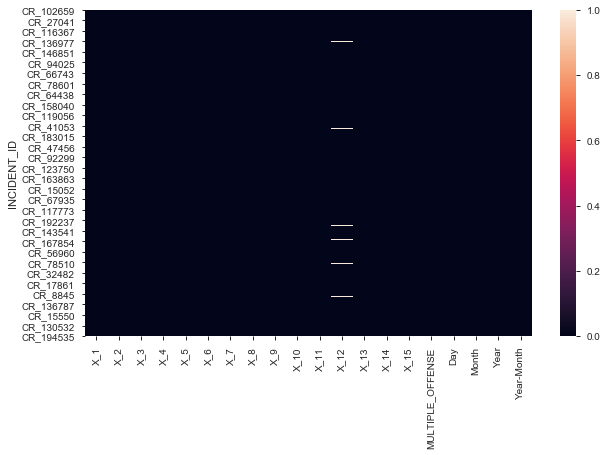

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.isnull(train_df))

In [16]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
X_12,182,0.007629
Year-Month,0,0.000000
X_9,0,0.000000
X_2,0,0.000000
X_3,0,0.000000
X_4,0,0.000000
X_5,0,0.000000
X_6,0,0.000000
X_7,0,0.000000
X_8,0,0.000000


In [17]:
train_df["X_12"].value_counts()

1.0     15674
0.0      5171
2.0      2039
3.0       476
4.0       176
5.0        59
6.0        36
8.0         9
10.0        7
9.0         6
7.0         4
11.0        4
15.0        2
20.0        2
17.0        1
58.0        1
50.0        1
40.0        1
16.0        1
90.0        1
12.0        1
30.0        1
14.0        1
Name: X_12, dtype: int64

**Data is skewed and to handle that I'm going to use mode to impute data** 

In [18]:
train_df["X_12"] = train_df["X_12"].fillna(train_df["X_12"].mode()[0])

In [19]:
train_df.head()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,Day,Month,Year,Year-Month
INCIDENT_ID,,,,,,,,,,,,,,,,,,,,
CR_102659,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0,4,7,2004,2004-07-01
CR_189752,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1,18,7,2017,2017-07-01
CR_184637,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1,15,3,2017,2017-03-01
CR_139071,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1,13,2,2009,2009-02-01
CR_109335,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1,13,4,2005,2005-04-01


### Let's see how data is distributed between Year and Month.

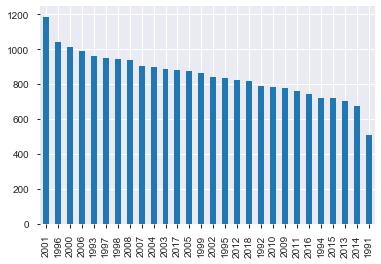

In [20]:
train_df['Year'].value_counts().plot.bar()

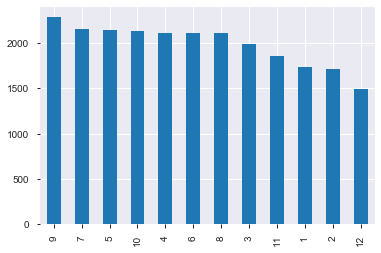

In [21]:
train_df['Month'].value_counts().plot.bar()

### Checking how the data is split across time

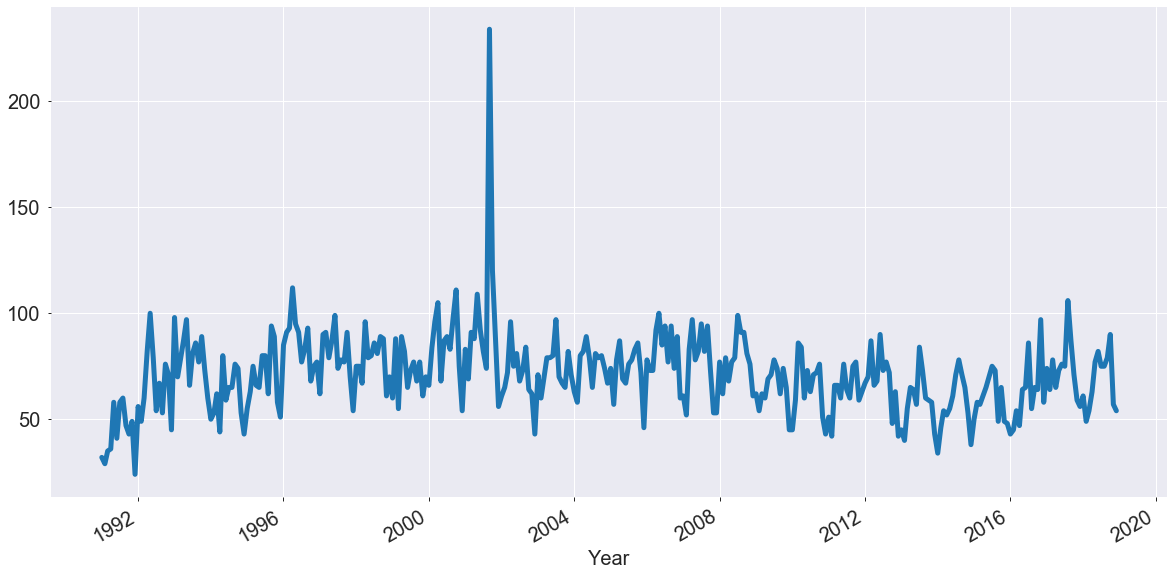

In [22]:
train_df['Year-Month'].value_counts().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [23]:
train_df['Year-Month'].value_counts().head()

2001-09-01    234
2001-10-01    120
1996-04-01    112
2000-10-01    111
2001-05-01    109
Name: Year-Month, dtype: int64

In [24]:
train_df.shape

(23856, 20)

**Since the data is having only one peak across the timeframe, I believe it is an Outlier and I might not remove it if test data has the same trend**

In [25]:
# train_df =train_df[(train_df.Month!=9)&(train_df.Year!= 2001)]

In [26]:
# train_df.shape

**Checking the data on every feature that's present**

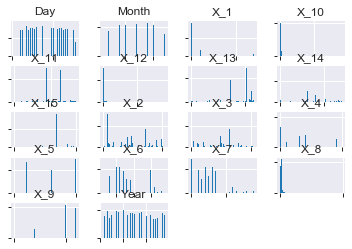

In [27]:
df = train_df.drop(["MULTIPLE_OFFENSE"], axis=1)

# create a histogram plot of each numeric variable
ax = df.hist(bins=100)

# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])

plt.show()

**Data is not Normal, I'll be Standardizing the data**

#### Splitting the data and removing the unwanted features

In [28]:
X = train_df.drop(['MULTIPLE_OFFENSE', 'Year-Month', 'X_2'],axis=1)
Y = train_df['MULTIPLE_OFFENSE']

### Standardizing the data

In [29]:
scaler = StandardScaler()

In [30]:
train_data = scaler.fit_transform(X)

In [31]:
train_Data = pd.DataFrame(train_data,columns=X.columns,index=train_df.index)

### Splitting the data into train_test_split (70-30)

In [32]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(train_Data, Y, test_size=0.3, random_state=100)

#### Checking the model to identify which model is performing better on valid Dataset.

In [33]:
models = [LogisticRegression(random_state=7),DecisionTreeClassifier(random_state=7),RandomForestClassifier(n_estimators=100),
          KNeighborsClassifier(n_neighbors=3),SVC(random_state=7), LinearSVC(random_state=9), xgb.XGBClassifier(random_state=7),
          GradientBoostingClassifier()]

In [34]:
def training_the_model(X, y, X_valid, y_valid, i):
    models = i
    kfold = KFold(n_splits=10, random_state=7)
    results = cross_val_score(models, X, y, cv=kfold)
    acc_lomo = "Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*110)
    models.fit(X, y)
    models_predictions_train = models.predict(X_valid)
    return (acc_lomo, confusion_matrix(y_valid,models_predictions_train),recall_score(y_valid,models_predictions_train))

In [35]:
Model_Output = {}

for i in models:
    Model_Output[i] = training_the_model(X_train, y_train, X_valid,y_valid, i)

In [36]:
Model_Output

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): ('Accuracy: 95.65% (0.37%)',
  array([[  36,  277],
         [  32, 6812]], dtype=int64),
  0.9953243717124488),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=7, splitter='best'): ('Accuracy: 99.81% (0.09%)',
  array([[ 298,   15],
         [   3, 6841]], dtype=int64),
  0.9995616598480421),
 RandomForestC

### As we can see GradientBoostingClassifier is performing best. The False Negative is only 1 and the recall score is best for GradientBoostingClassifier.

In [37]:
# GBC

model = GradientBoostingClassifier()

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)

acc_lomo = "Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*110)
print(acc_lomo)

model.fit(X_train,y_train)
GBC_predictions_train = model.predict(X_valid)
print(classification_report(y_valid,GBC_predictions_train))
print(confusion_matrix(y_valid,GBC_predictions_train))
print(recall_score(y_valid,GBC_predictions_train))

Accuracy: 99.86% (0.07%)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       313
           1       1.00      1.00      1.00      6844

    accuracy                           1.00      7157
   macro avg       1.00      0.99      0.99      7157
weighted avg       1.00      1.00      1.00      7157

[[ 304    9]
 [   1 6843]]
0.999853886616014


## Test file prepration

In [38]:
test_df_main = pd.read_csv("Test.csv")

In [39]:
test_df = test_df_main.copy()

In [40]:
test_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [41]:
corr = test_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
X_1,1.000000,0.030496,0.030976,-0.005326,-0.039203,0.414001,0.425840,-0.067898,0.014131,-0.014896,0.004205,-0.064810,0.101348,-0.001934,-0.021650
X_2,0.030496,1.000000,0.996932,-0.104985,-0.364487,0.123955,0.069277,-0.052522,-0.027721,-0.025326,0.054676,-0.083900,0.044121,0.019978,0.007575
X_3,0.030976,0.996932,1.000000,-0.076411,-0.364235,0.129570,0.084448,-0.049484,-0.028606,-0.022261,0.053582,-0.080060,0.042015,0.018218,0.001069
X_4,-0.005326,-0.104985,-0.076411,1.000000,0.422509,0.019798,0.097095,0.058194,-0.035503,0.042284,-0.051579,0.068968,-0.048783,-0.022423,-0.037745
X_5,-0.039203,-0.364487,-0.364235,0.422509,1.000000,-0.069090,0.004112,0.062754,0.029654,0.062653,-0.060479,0.107222,-0.074455,-0.013293,-0.051209
X_6,0.414001,0.123955,0.129570,0.019798,-0.069090,1.000000,0.693056,-0.065980,0.086701,0.018853,-0.006849,-0.057221,0.049206,-0.011291,-0.016444
X_7,0.425840,0.069277,0.084448,0.097095,0.004112,0.693056,1.000000,-0.018485,0.017643,0.031901,-0.008877,-0.004669,0.005569,0.006395,-0.013684
X_8,-0.067898,-0.052522,-0.049484,0.058194,0.062754,-0.065980,-0.018485,1.000000,-0.108924,0.123427,-0.025773,0.204437,-0.055066,0.002362,0.020029
X_9,0.014131,-0.027721,-0.028606,-0.035503,0.029654,0.086701,0.017643,-0.108924,1.000000,-0.006901,-0.005082,-0.018356,0.030556,-0.304968,-0.003338
X_10,-0.014896,-0.025326,-0.022261,0.042284,0.062653,0.018853,0.031901,0.123427,-0.006901,1.000000,-0.051959,0.749450,0.000625,-0.004596,-0.011161


Even in this test dataset we are able to notice that **X_2** and **X_3** are highly correlated. So, I'll be removing either of them.

#### Creating Date, Month and Year from the DATE column

In [42]:
test_df = Day_Month_Year(test_df)

In [43]:
test_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Day,Month,Year,Year-Month
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23,1,2,2018,2018-02-01
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,5,3,2004,2004-03-01
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,27,1,2018,2018-01-01
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,18,8,2006,2006-08-01
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,31,10,2011,2011-10-01


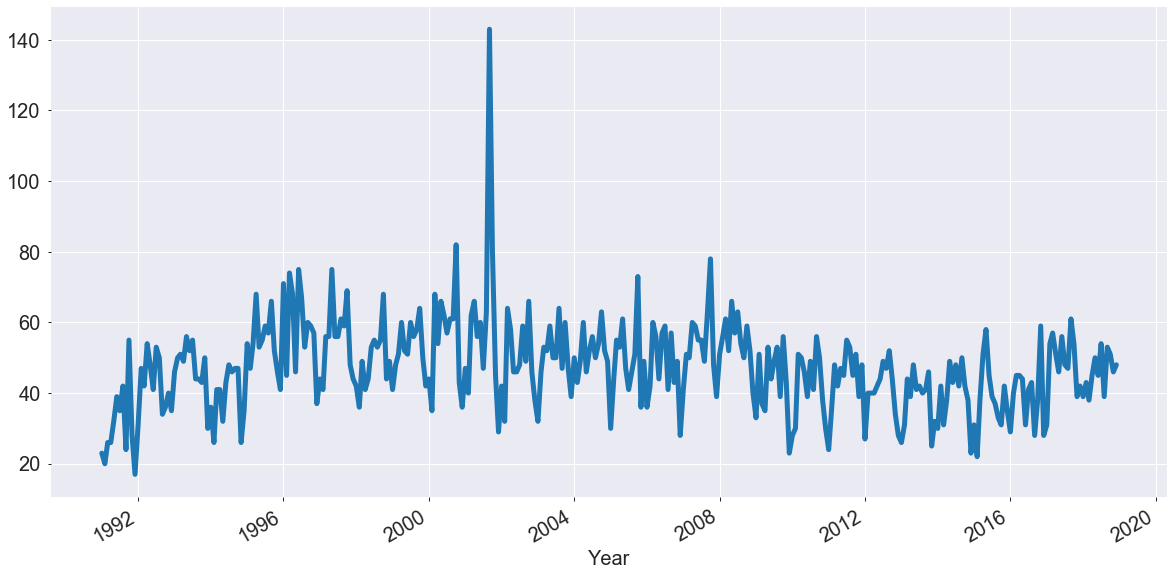

In [44]:
test_df['Year-Month'].value_counts().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

In [45]:
test_df['Year-Month'].value_counts().head()

2001-09-01    143
2000-10-01     82
2001-10-01     80
2007-10-01     78
1997-05-01     75
Name: Year-Month, dtype: int64

**Since there is a spike on the same day on Test dataset as we saw on Train dataset. I'm not removing it.**

In [46]:
test_df = test_df.set_index(test_df.INCIDENT_ID)

In [47]:
test_df.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Day,Month,Year,Year-Month
INCIDENT_ID,,,,,,,,,,,,,,,,,,,,,
CR_195453,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23,1,2,2018,2018-02-01
CR_103520,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34,5,3,2004,2004-03-01
CR_196089,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34,27,1,2018,2018-01-01
CR_112195,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34,18,8,2006,2006-08-01
CR_149832,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43,31,10,2011,2011-10-01


#### Removing the unwanted features

In [48]:
test_df.drop('INCIDENT_ID',axis=1,inplace=True)
test_df.drop('DATE',axis=1,inplace=True)
test_df.drop('Year-Month',axis=1,inplace=True)
test_df.drop('X_2',axis=1,inplace=True)

#### Mode imputation on Null data

In [49]:
test_df["X_12"] = test_df["X_12"].fillna(test_df["X_12"].mode()[0])

In [50]:
test_df.head(2)

,X_1,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Day,Month,Year
INCIDENT_ID,,,,,,,,,,,,,,,,,
CR_195453,0,35,7,3,6,4,0,5,1,174,1.0,72,119,23,1,2,2018
CR_103520,0,44,1,3,7,1,4,6,1,316,0.0,12,29,34,5,3,2004


### Standardizing the data

In [51]:
test_data = scaler.transform(test_df)

In [52]:
test_Data = pd.DataFrame(test_data,columns=test_df.columns,index=test_df.index)

In [53]:
test_Data.head()

,X_1,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,Day,Month,Year
INCIDENT_ID,,,,,,,,,,,,,,,,,
CR_195453,-0.336025,0.684685,0.924827,0.277319,-0.034478,-0.225797,-0.669225,0.055682,-0.218714,-0.354230,0.022126,-0.479674,1.069966,-1.247785,-1.659719,-1.368916,1.764060
CR_103520,-0.336025,1.279342,-1.112794,0.277319,0.189152,-0.998624,2.083484,0.789575,-0.218714,1.172136,-0.837542,-2.653851,-1.008728,0.063822,-1.203898,-1.065309,-0.031959
CR_196089,-0.336025,0.552539,-0.433587,1.296140,-0.929000,0.547031,1.395307,-3.613784,-0.218714,1.172136,0.022126,-0.479674,-1.678529,0.063822,1.303121,-1.672523,1.764060
CR_112195,4.526073,-1.495724,-0.433587,1.296140,0.636413,0.804640,-0.669225,0.055682,-0.218714,-0.354230,0.022126,0.969778,0.330875,0.063822,0.277523,0.452725,0.224615
CR_149832,-0.336025,-1.099286,0.924827,0.277319,-0.929000,0.547031,0.018953,0.055682,-0.218714,-0.354230,-0.837542,0.969778,0.469455,1.136955,1.758943,1.059939,0.866050


### Predicting the data using GradientBoostingClassifier

In [54]:
y_pred_test = model.predict(test_Data)

In [55]:
Output = pd.DataFrame({'MULTIPLE_OFFENSE':y_pred_test},index=test_Data.index)

In [56]:
# Output.to_csv('Outcome_16.csv')